# Plot along-gene mutation rates

Of genes we're interested in in CAMP. But we could of course generalize this / show multiple genes at once.

### TODO: Actually use the `reverse_strand` parameter.
This should flip CPs 1 and 3, so rather than going [1, 2, 3, 1, 2, 3, ...] it should go [3, 2, 1, 3, 2, 1, ...]

Shouldn't really be difficult but time is scarce right now...

In [1]:
%run "Header.ipynb"

In [2]:
%run "LoadMutationJSONData.ipynb"
%run "GeneUtils.ipynb"

## Define utility functions for plotting

In [3]:
def plot_gene_mutation_spectrum(seq, leftend, rightend, ax, cutoff=None, reverse_strand=False):
    """leftend must be < rightend -- so if this is a reverse gene,
    the end position should still be leftend, I think.
    
    "cutoff" can optionally be a float. If cutoff is not None, then this'll print out
    information about the number of positions where the percentage of mismatches is >= cutoff.
    (Mostly useful for adding to figure captions...)
    """
    one_cycle_through = False
    gene_positions = range(leftend, rightend + 1)
    if len(gene_positions) % 3 != 0:
        raise ValueError("Gene length not divisible by 3")
    cp = 1
    
    max_mutation_pct = float("-inf")
    
    num_called_mutations = 0
    called_mutations_in_cps = [0, 0, 0]
    called_mutations_pcts = []
    called_mutations_positions = []
    # We adopt the strategy here of calling .scatter() for each data point to plot, rather than
    # building up lists of x-axis, y-axis, and color values and plotting that. See e.g.
    # https://stackoverflow.com/questions/42180475#comment71523984_42180475 for documentation on this.
    for p in gene_positions:
        sp = str(p)
        cov = seq2pos2mismatchct[seq][sp] + seq2pos2matchct[seq][sp]
        pct = seq2pos2mismatchct[seq][sp] / cov
        max_mutation_pct = max(max_mutation_pct, pct)
        # If we assign a label to every datapoint, then the duplicate labels show up in the legend.
        # To avoid this, we just only assign labels to the first three points at a codon position:
        # https://stackoverflow.com/a/19386045.
        label = "" if one_cycle_through else "Codon Position {}".format(cp)
        ax.scatter(p, pct, c=cp2color[cp], label=label, edgecolor=BORDERCOLOR)
        if cp == 3:
            cp = 1
            one_cycle_through = True
        else:
            cp += 1
        if cutoff is not None and pct >= cutoff:
            num_called_mutations += 1
            called_mutations_in_cps[cp - 1] += 1
            called_mutations_pcts.append(pct)
            called_mutations_positions.append(p)
    
    if cutoff is not None:
        print("{} / {} positions have a mismatch rate >= the cutoff of {}".format(
            num_called_mutations, len(gene_positions), cutoff
        ))
        # Avoid printing details if no "mutations" were identified here -- mean() will throw an error, at least
        # as of writing, if passed an empty collection.
        if num_called_mutations > 0:
            print("{} mutations in CP 1; {} mutations in CP 2; {} mutations in CP 3.".format(*called_mutations_in_cps))
            print("Average mutation rate among these {} positions is {:.2f}%.".format(
                num_called_mutations, mean(called_mutations_pcts) * 100
            ))
            print("These exact positions are {}".format(called_mutations_positions))

    ax.set_title("Mutation spectrum")
    # Hide x-axis label for now, since we don't need this when tiling this plot on top of a coverage plot
#     ax.set_xlabel("Sequence position")
    # https://stackoverflow.com/a/27474400 -- need to use raw string
    # https://stackoverflow.com/a/23856968 -- can use \mathrm{} to substitute for \text{}
    ax.set_ylabel(r"$\dfrac{\mathrm{Mismatches}}{\mathrm{Mismatches + Matches}}$")
    
    # Hack for the "control" gene
    if max_mutation_pct < 0.005:
        ax.set_ylim(0, 0.005)
        decimals = 2
    else:
        ax.set_ylim(0)
        decimals = 0
        
    ax.legend()
    print("Maximum mutation rate is {:.2f}%".format(max_mutation_pct * 100))
    # Disable "offset" on the x-axis. This prevents matplotlib from replacing literal sequence positions with
    # smaller numbers and then adding a "+1.21e6" off to the side of the axis (which is... a lot more confusing
    # for this particular application than just listing the actual sequence positions). Doing this *after* the
    # percentage thing below doesn't seem to work, but doing it up here works. I dunno, matplotlib is hard.
    # See https://stackoverflow.com/a/28373421.
    ax.ticklabel_format(useOffset=False)
    
    # Make the y-axis show percentages: based on
    # https://old.reddit.com/r/learnpython/comments/7adhnk/matplotlib_setting_y_axis_labels_to_percent_yaxis/dp93fwq/
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=decimals))
    
    # Use thousands separator on the x-axis
    use_thousands_sep(ax.get_xaxis())

In [4]:
def plot_gene_coverage(seq, leftend, rightend, ax, reverse_strand=False):
    gene_positions = range(leftend, rightend + 1)
    if len(gene_positions) % 3 != 0:
        raise ValueError("Gene length not divisible by 3")
    one_cycle_through = False
    cp = 1
    min_cov = float("inf")
    all_covs = []
    for p in gene_positions:
        cov = seq2pos2totalcov[seq][str(p)]
        all_covs.append(cov)
        min_cov = min(min_cov, cov)
        label = "" if one_cycle_through else "Codon Position {}".format(cp)
        ax.scatter(p, cov, c=cp2color[cp], label=label, edgecolor=BORDERCOLOR)
        if cp == 3:
            cp = 1
            one_cycle_through = True
        else:
            cp += 1
    
    print("The lowest-coverage position in this entire gene has coverage {:,}x.".format(min_cov))
    print("This gene has an average coverage of {:,}x.".format(mean(all_covs)))
    print("...(The sum of all positions' coverages is {:,}x, for reference.)".format(sum(all_covs)))
    ax.set_title("Coverage")
    ax.set_xlabel("Sequence position")
    ax.set_ylabel("Mismatches + Matches")
    ax.legend()
    ax.ticklabel_format(useOffset=False)
    use_thousands_sep(ax.get_xaxis())
    use_thousands_sep(ax.get_yaxis())

In [5]:
def mutation_spectrum_and_coverage_plots(seq, leftend, rightend, cutoff=None, figfilename=None, reverse_strand=False):
    fig, (ax1, ax2) = pyplot.subplots(2)
    plot_gene_mutation_spectrum(seq, leftend, rightend, ax1, cutoff=cutoff, reverse_strand=reverse_strand)
    plot_gene_coverage(seq, leftend, rightend, ax2, reverse_strand=reverse_strand)
    fig.suptitle(
        "Gene (left end: {:,}, right end: {:,}) in {}".format(
            leftend, rightend, seq2name[seq]
        ),
        fontsize="15",
        y=0.93
    )
    fig.set_size_inches(15, 12)
    if figfilename is not None:
        fig.savefig("figs/{}".format(figfilename), bbox_inches="tight")

## Along-gene mutation rates for gene 1217 in CAMP (which exhibits "binarized" mutation rates)
The reason we go with this gene is it stood out really clearly in an earlier version of this analysis, where we were using the scaffold for CAMP rather than a single edge. It's still an outlier in the plot, just not the you know hugest one. That's understandable -- we've changed a lot about the way we process the data throughout the span of this project.

34 / 1149 positions have a mismatch rate >= the cutoff of 0.14
30 mutations in CP 1; 2 mutations in CP 2; 2 mutations in CP 3.
Average mutation rate among these 34 positions is 15.94%.
These exact positions are [1209001, 1209010, 1209022, 1209058, 1209104, 1209115, 1209121, 1209126, 1209133, 1209136, 1209142, 1209145, 1209148, 1209154, 1209205, 1209241, 1209265, 1209266, 1209297, 1209322, 1209325, 1209337, 1209400, 1209403, 1209418, 1209421, 1209424, 1209523, 1209577, 1209610, 1209697, 1209700, 1209757, 1209796]
Maximum mutation rate is 16.16%
The lowest-coverage position in this entire gene has coverage 4,407x.
This gene has an average coverage of 4,548.20365535248x.
...(The sum of all positions' coverages is 5,225,886x, for reference.)


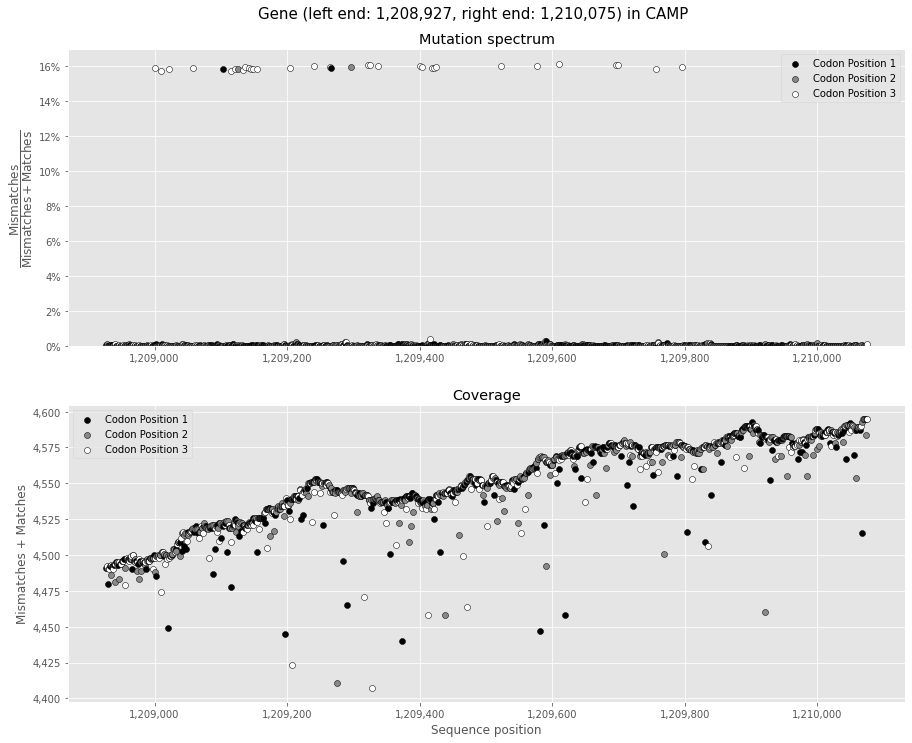

In [6]:
# We pass cutoff=0.14 so the function will count the number of positions above a 14% mutation rate
# The "center" is obvs closer to 16%, but to be careful and make sure we count everything we set it to 14%

# To count positions with mutation frequency of > 0.5%, set cutoff=0.005. 
mutation_spectrum_and_coverage_plots("edge_6104", 1208927, 1210075, cutoff=0.14, figfilename="g1.png")

## Along-gene mutation rates for gene 206 in CAMP (slightly less clearly defined pattern, but still roughly binary)

167 / 1554 positions have a mismatch rate >= the cutoff of 0.4
92 mutations in CP 1; 44 mutations in CP 2; 31 mutations in CP 3.
Average mutation rate among these 167 positions is 46.86%.
These exact positions are [198928, 198931, 198991, 199048, 199126, 199213, 199216, 199219, 199264, 199300, 199321, 199326, 199331, 199334, 199336, 199337, 199338, 199343, 199344, 199345, 199346, 199348, 199349, 199350, 199355, 199361, 199362, 199363, 199370, 199375, 199376, 199387, 199399, 199411, 199435, 199436, 199438, 199441, 199442, 199445, 199446, 199449, 199456, 199459, 199465, 199483, 199486, 199504, 199505, 199509, 199562, 199564, 199567, 199574, 199576, 199579, 199590, 199591, 199594, 199601, 199604, 199615, 199618, 199630, 199633, 199634, 199648, 199651, 199672, 199681, 199684, 199696, 199697, 199698, 199699, 199706, 199708, 199711, 199732, 199734, 199735, 199738, 199741, 199745, 199747, 199750, 199751, 199752, 199754, 199755, 199757, 199759, 199764, 199765, 199770, 199774, 199777, 199778, 1

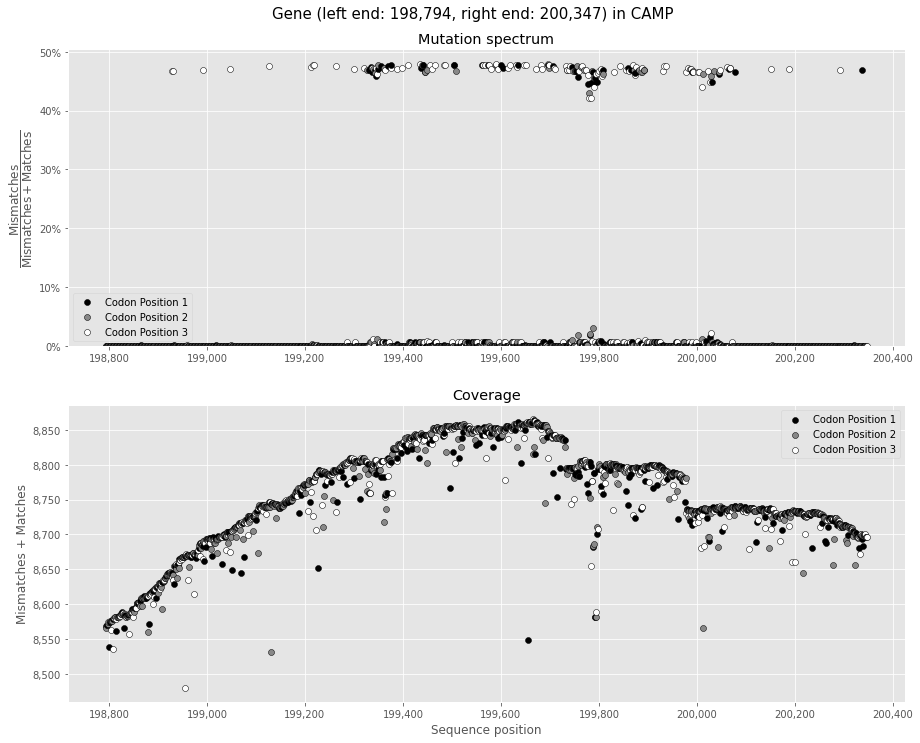

In [7]:
# The gene we're going to plot here is number 206.
mutation_spectrum_and_coverage_plots("edge_6104", 198794, 200347, cutoff=0.4, figfilename="g2.png")

Maximum mutation rate is 0.41%
The lowest-coverage position in this entire gene has coverage 4,672x.
This gene has an average coverage of 4,854x.
...(The sum of all positions' coverages is 1,296,018x, for reference.)


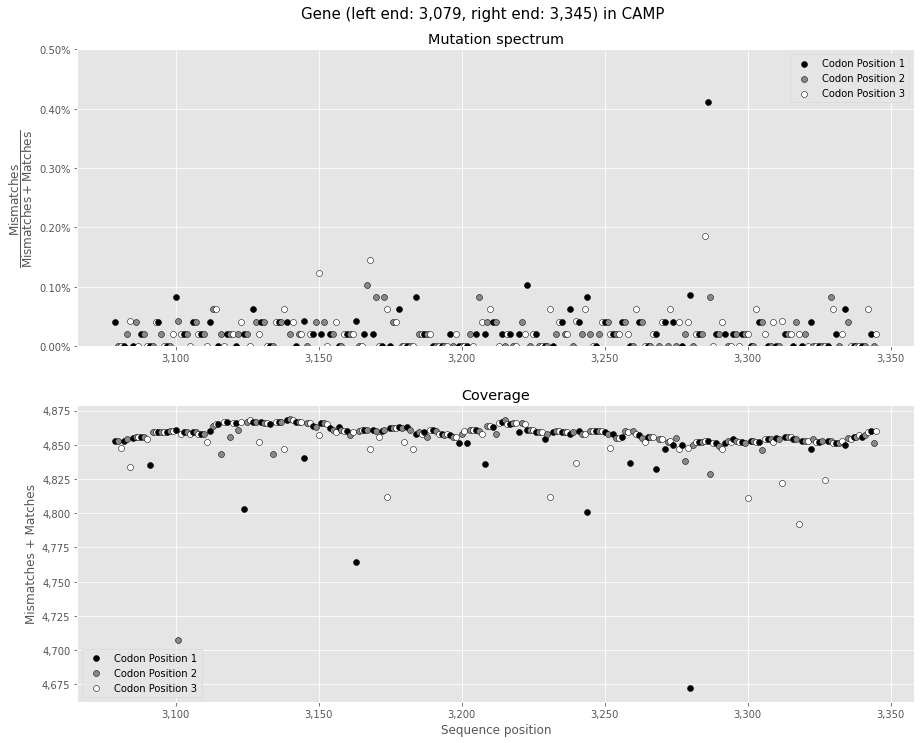

In [8]:
# The first forward strand gene found by prodigal, for comparison to the outliers
# >5_3079_3345_+
mutation_spectrum_and_coverage_plots("edge_6104", 3079, 3345, figfilename="g3.png")

Maximum mutation rate is 0.27%
The lowest-coverage position in this entire gene has coverage 4,765x.
This gene has an average coverage of 4,867.968680089485x.
...(The sum of all positions' coverages is 2,175,982x, for reference.)


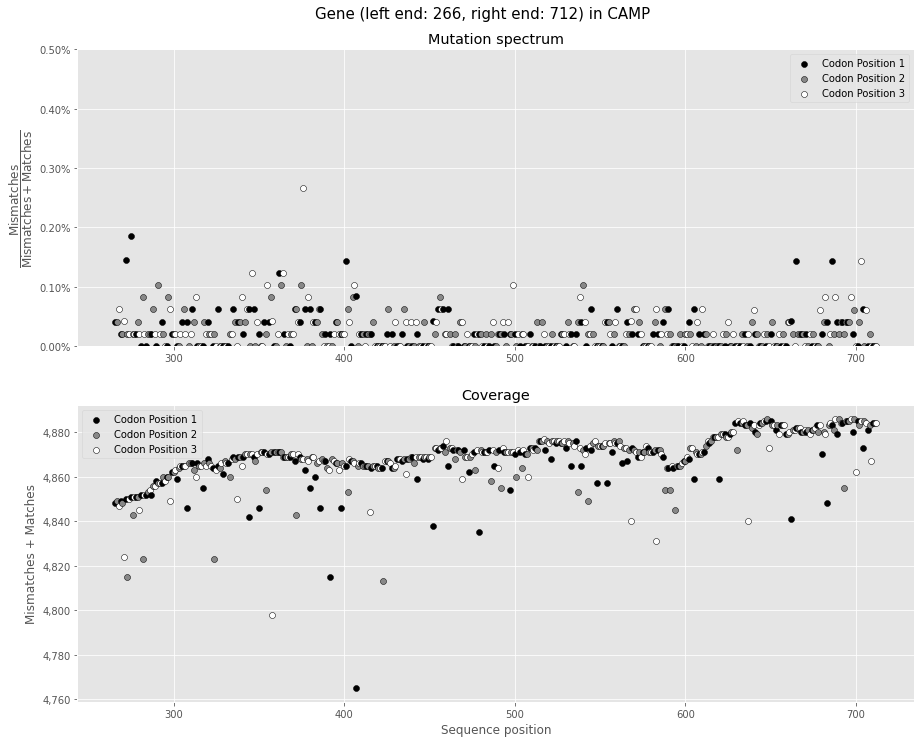

In [9]:
# The first gene, just for fun
# NOTE: This gene is tagged as negative so CPs 1 and 3 should be inverted in the coloring - TODO support that...
mutation_spectrum_and_coverage_plots("edge_6104", 266, 712, reverse_strand=True)

Maximum mutation rate is 52.78%
The lowest-coverage position in this entire gene has coverage 3,979x.
This gene has an average coverage of 5,010.500952380952x.
...(The sum of all positions' coverages is 7,891,539x, for reference.)


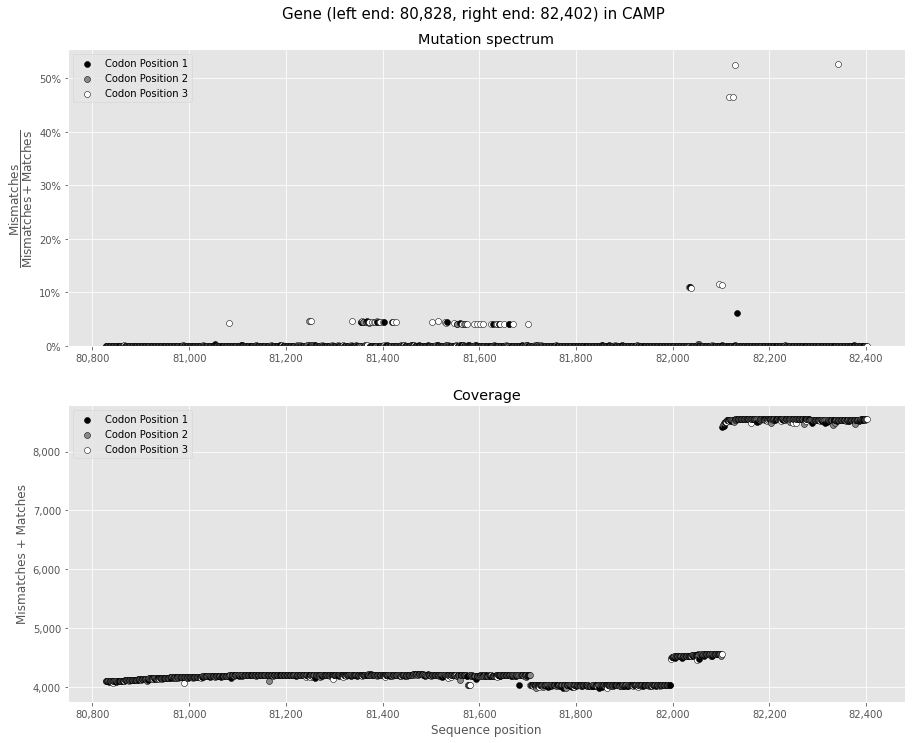

In [10]:
# Another outlier gene going by the scatterplots -- gene 89_80828_82402_+
mutation_spectrum_and_coverage_plots("edge_6104", 80828, 82402)

Maximum mutation rate is 17.77%
The lowest-coverage position in this entire gene has coverage 4,248x.
This gene has an average coverage of 4,738.073371283997x.
...(The sum of all positions' coverages is 7,490,894x, for reference.)


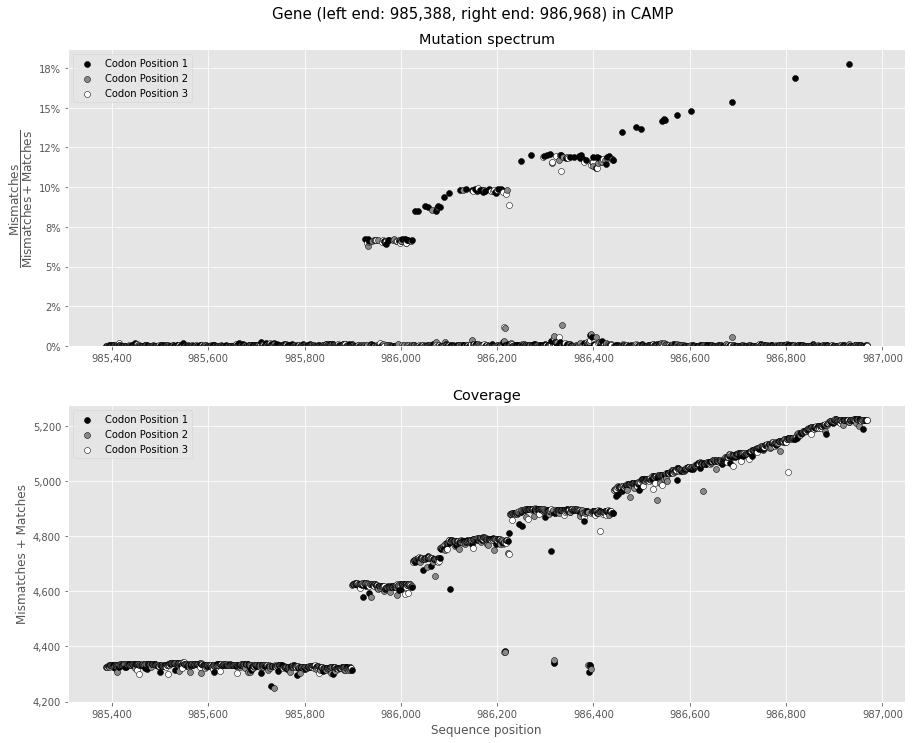

In [11]:
# Another outlier gene going by the scatterplots -- gene 970_985388_986968_-
# NOTE: this is negative, so CP 1 and 3 should be flipped
mutation_spectrum_and_coverage_plots("edge_6104", 985388, 986968, reverse_strand=True)

## An extra thing: create a histogram of the number of reads with a given number of mutations within a gene

Intended to emphasize the "binary" nature of the mutation spectra.

In [12]:
import json
from collections import Counter

In [13]:
with open(
    "/Poppy/mfedarko/sheep_metagenome/redo_work_big_nonhaplo_graph/read-mutcts-in-gene.txt", "r"
) as f:
    # https://stackoverflow.com/a/35461204
    # this is a pretty lazy way of moving a python list from a cluster to my laptop but it works
    read_mp_cts = json.load(f)

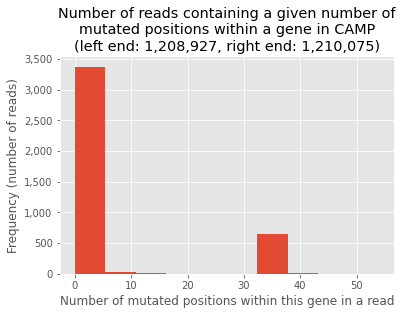

In [14]:
pyplot.hist(read_mp_cts)
pyplot.title(
    (
        "Number of reads containing a given number of\n"
        "mutated positions within a gene in {}\n"
        "(left end: {:,}, right end: {:,})"
    ).format(
        seq2name["edge_6104"], 1208927, 1210075
    )
)
use_thousands_sep(pyplot.gca().get_yaxis())
pyplot.ylabel("Frequency (number of reads)")
pyplot.xlabel("Number of mutated positions within this gene in a read")
pyplot.savefig("figs/g1-read-mutation-histogram.png", bbox_inches="tight")

In [15]:
# Heeding the wisdom of https://stackoverflow.com/a/2600208
# ... it's been a long night
c = Counter(read_mp_cts)
geq_32_ct = 0
for num_mutated_positions in c.keys():
    print("{} reads have {} mutated positions within the gene.".format(
        c[num_mutated_positions], num_mutated_positions
    ))
    if num_mutated_positions >= 32:
        geq_32_ct += c[num_mutated_positions]
print("ALSO: {} reads total have >= 32 mutated positions within the gene.".format(geq_32_ct))

3023 reads have 0 mutated positions within the gene.
172 reads have 1 mutated positions within the gene.
86 reads have 2 mutated positions within the gene.
53 reads have 3 mutated positions within the gene.
26 reads have 4 mutated positions within the gene.
16 reads have 5 mutated positions within the gene.
11 reads have 6 mutated positions within the gene.
9 reads have 7 mutated positions within the gene.
4 reads have 8 mutated positions within the gene.
1 reads have 9 mutated positions within the gene.
1 reads have 10 mutated positions within the gene.
2 reads have 11 mutated positions within the gene.
3 reads have 12 mutated positions within the gene.
1 reads have 13 mutated positions within the gene.
1 reads have 16 mutated positions within the gene.
1 reads have 18 mutated positions within the gene.
1 reads have 19 mutated positions within the gene.
1 reads have 32 mutated positions within the gene.
34 reads have 33 mutated positions within the gene.
567 reads have 34 mutated posi